In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
grid_size = 200  # Start with a smaller grid size
total_iterations = 600

# Reaction-Diffusion parameters 
pa = 0.5
pb = 0.8
pc = 0.16
pe = 2.6
d = 30
dt = 1e-1
dx = 0.02
threshold = 1
pk = 0.05
gamma = 625
ph = 1
alpha = 1
amax = 60  # activator limiter
smax = 80  # suppressor limiter
width = 0.4  # width of dendrites (1 for normal)

# Initial conditions for u, v, c, and n
u = np.zeros((grid_size, grid_size))
v = np.zeros((grid_size, grid_size))
c = np.zeros((grid_size, grid_size))
c_new = np.copy(c)
u_new = np.copy(u)
v_new = np.copy(v)

# Nutrient landscape
mid = grid_size // 2
n = np.ones((grid_size, grid_size))
n[:, mid:] = 0.3

# Rocks (obstacles) on substrate that spawn randomly
num_rocks = 50
max_rock_size = 10
exclusion_zone = 20
np.random.seed()  # Ensure different rocks each run

for _ in range(num_rocks):
    rock_size = np.random.randint(1, max_rock_size)
    x = np.random.randint(rock_size, grid_size - rock_size)
    y = np.random.randint(rock_size, grid_size - rock_size)

    # Check if the rock is in the exclusion zone
    if abs(x - mid) > (exclusion_zone + rock_size) and abs(y - mid) > (exclusion_zone + rock_size):
        n[x - rock_size:x + rock_size, y - rock_size:y + rock_size] = 0

# Initial activator and suppressor states
for k in range(-6, 7):
    for j in range(mid-k, mid+k+1):
        for l in range(mid-k, mid+k+1):
            u[j, l] = 0.5 + np.random.rand() / 100
            v[j, l] = 0.1 + np.random.rand() / 100
    c[mid-k:mid+k+1, mid-k+1:mid+k+1] = 1

ij_mat = np.zeros((grid_size, grid_size))

In [5]:
# Function for updating visualizations
def update_visualization(step, u, v, c, n):
    plt.subplot(2, 2, 1)
    plt.imshow(u, cmap='jet', vmin=0, vmax=amax)
    plt.title(f'Activator u at iteration {step}')
    plt.colorbar()
    
    plt.subplot(2, 2, 2)
    plt.imshow(v, cmap='jet', vmin=0, vmax=smax)
    plt.title(f'Suppressor v at iteration {step}')
    plt.colorbar()

    plt.subplot(2, 2, 3)
    plt.imshow(c, cmap='jet', vmin=-1, vmax=1)
    plt.title(f'Mycelium at iteration {step}')
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.imshow(np.rot90(np.rot90(n)), cmap='jet')
    plt.title('Substrate')
    plt.colorbar()

    plt.tight_layout()
    plt.draw()
    plt.pause(0.01)
    plt.clf()

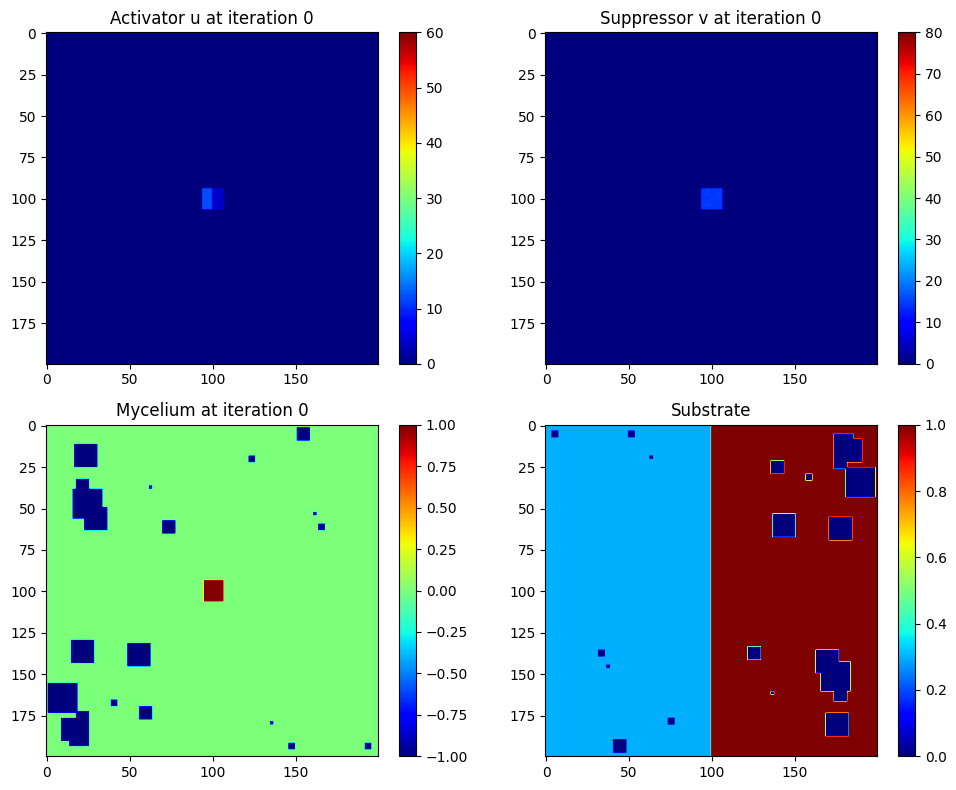

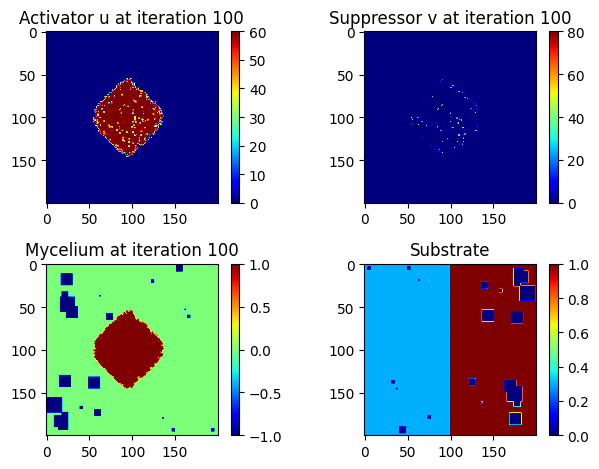

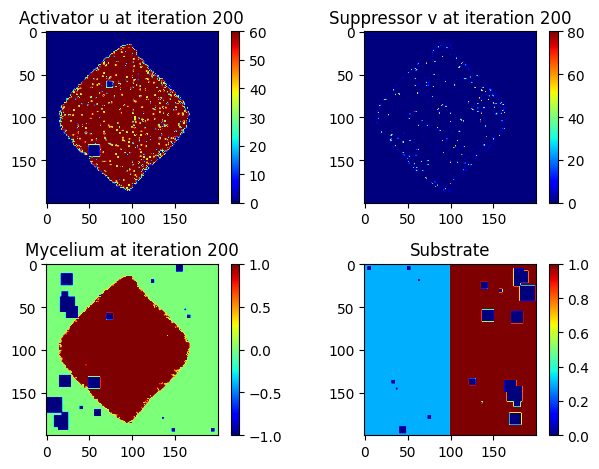

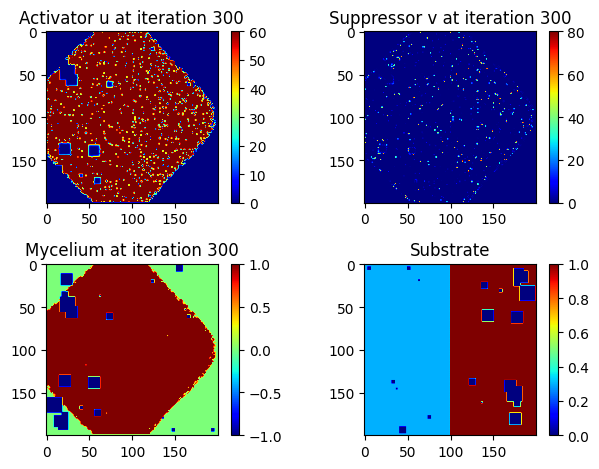

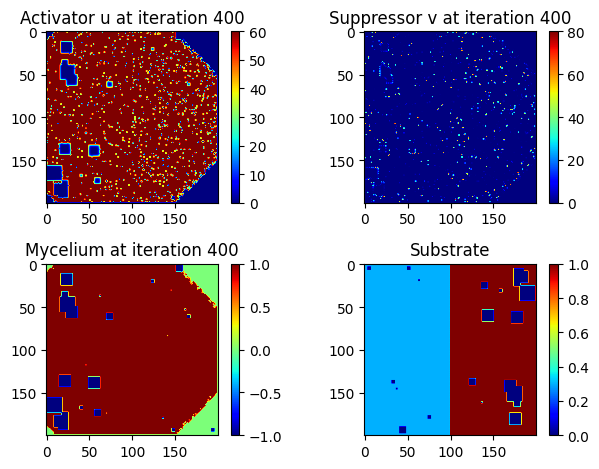

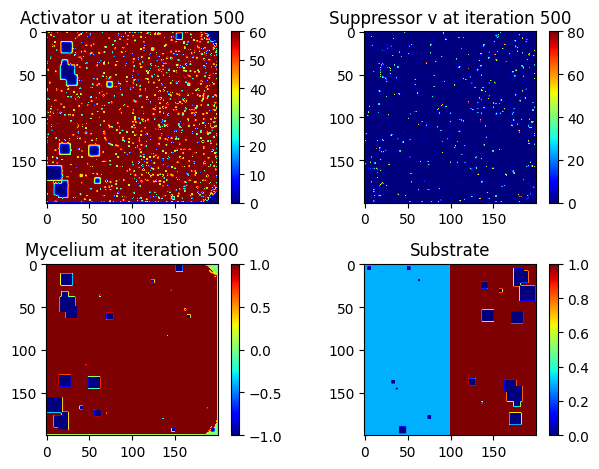

<Figure size 640x480 with 0 Axes>

In [6]:
# Main simulation loop
plt.figure(figsize=(10, 8))
for step in range(total_iterations):
    # Reaction Terms that control chemical behavior
    f_uv = width * (pa*u + u**2 - pb*u*v) * n
    g_uv = pe*u**3 - v

    # Incorporate the radius of the plasmatic membrane
    for i in range(4, grid_size-4):
        for j in range(4, grid_size-4):
            if c[i, j] > 0.5:
                for di in range(-4, 5):
                    for dj in range(-4, 5):
                        if 0 <= i + di < grid_size and 0 <= j + dj < grid_size:
                            ij_mat[i + di, j + dj] = 1

    for i in range(1, grid_size-1):
        for j in range(1, grid_size-1):
            if ij_mat[i, j] > 0.5:
                v_new[i, j] = v[i, j] + dt * (d * (0.05*v[i+1,j] + 0.05*v[i-1,j] + 0.05*v[i,j+1] + 0.05*v[i,j-1] - 0.2*v[i,j]) + gamma * g_uv[i, j])
                u_new[i, j] = u[i, j] + dt * (0.05*(u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1]) - 0.2*u[i,j] + gamma * f_uv[i, j])

            if u[i, j] <= threshold:
                alpha = 0.49
            else:
                alpha = 0.49 - 2.5 * (u[i, j] - threshold)
                v_new[i, j] = 0

            c_new[i, j] = c[i, j] + dt * (gamma * ph * c[i, j] * (alpha - c[i, j]) * (c[i, j] - 1))

            if alpha < 0:
                c_new[i, j] = 1

            # Limiters of activator and suppressor to avoid exponential growth
            u_new[i, j] = np.clip(u_new[i, j], 0, amax)
            v_new[i, j] = np.clip(v_new[i, j], 0, smax)

            if n[i, j] == 0:
                c_new[i, j] = -1

    u = np.copy(u_new)
    v = np.copy(v_new)
    c = np.copy(c_new)

    # Visualization every 100 steps0
    if step % 100 == 0:
        update_visualization(step, u, v, c, n)